In [3]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib2
from bs4 import BeautifulSoup
from PIL import Image

# Project 2: Gathering crystallographic conditions

Background thoughts: Project 1 is more of an "application" than a "tool," and I had originally wanted to work on a project that would fall more in the category of the latter. However, I didn't have any ideas for anything that would be helpful for my lab or everyday activities. As I mentioned in the Project 1 descriptions, the experiments I've done in the lab don't tend to follow a strict layout or format, so writing a short chunk of code for data analysis could shorten a few steps but probably wouldn't be repeatedly very helpful. And though we do a fair amount of sequence checking, I feel like that's kind of beyond my capability because I would probably only be able to check for 100% matches.

After seeing some of the projects in the first week of presentations, I thought of the following project and wanted to test it out. But first, some introduction:

### Background on structural determination: X-ray crystallography, cryo-EM, and NMR

Many people are interested in knowing the structure of biological macromolecules. This obviously satisfies our curiosity about what certain proteins or biological complexes look like, but there is typically also the argument that understanding the structure will help us understand function (the NIH doesn't fund these projects just for curiosity's sake, after all). For example, knowing the structure of a protein can help us predict how it may interact with other proteins, or perhaps understanding the interaction in a protein-nucleic acid complex can help us understand how we may target this interaction with a drug.

When it comes to structural determination, there are typically three main methods: X-ray crystallography, cryo-EM, and NMR spectroscopy. NMR is limited to fairly small species (e.g. proteins <30kDa), and cryo-EM has historically been limited to larger molecules (e.g. proteins >200kDa) - though lately it has been getting better for smaller species. Both of these methods are in solution. In contrast, crystallography requires that you purify your species of interest and make crystals out of it. Then, you shoot these crystals with X-rays to obtain a diffraction pattern, from which you create an electron density map and subsequently solve the structure. There is technically no size restriction with crystallography, though it tends to be that smaller species are easier to crystallize because they tend to be less flexible. Thus, crystallography is a reasonable method to pursue if you want to determine the structure of a protein that is roughly under 200kDa, the soft border over which point it might be easier to do cryo-EM.

### Why I am interested and how crystallography works

In college and here at the NIH, I have worked / am working on crystallography projects. None of them have worked so far unfortunately! But they gave me the idea for the following project. Before I begin, some more background on specifically crystallography may be helpful: To try to crystallize a protein, you first purify that protein and concentrate it to high concentration. Then you mix your high concentration protein with what I will call a "condition," a particular mixture of buffers, salts, etc. Next, you hope that a crystal forms - that is, you hope that your condition will make it favorable for the protein to precipitate out in an ordered fashion to form a crystal. 

Typically, a condition consists of a buffer, a salt, and a precipitant like a polymer - for example, 0.1M HEPES pH 7, 1.4M potassium phosphate, 10% PEG 30000. You can buy these conditions premade in a 96-well block from companies that sell these sorts of reagents, and in these blocks, each well contains a different mix of buffers, salts, precipitants. There are many different matrices of conditions mixes in 96-well blocks that are sold commercially. Also, setup of initial crystallization screens is often assisted by a pipetting robot. So, in a first pass of crystallization, it would be pretty typical to screen >500 conditions at minimum. This is necessary because crystallography is largely a black box - it's extremely hard to predict what conditions would yield crystals and why. So, oftentimes you just need to try as many conditions as you can and hope that you find one that works.

However, one still wonders: do "similar" proteins tend to crystallize in similar conditions?

# Project goal: find crystallization conditions for proteins similar to a protein of interest

Let's say you want to crystallize a protein whose structure is currently unknown. Were similar proteins previously crystallized, and if yes, what were their crystallization conditions?

To answer this, we can search the PDB: Protein Data Bank. The PDB is a database of the known structures of biological macrolecules, such as individual proteins, protein-protein complexes, protein-nucleic acid complexes, etc. A particular structure is identified by its PDB ID, a unique four-character code. The PDB contains structures obtained by all sorts of methods - so not just X-ray crystallography (which is the focus of this project) but also cryo-EM, etc.

Here is what a picture of a PDB page looks like. There's a lot of information for each structure, including associated publications. The "Experiment" tab of the page is where we can find the crystallization and diffraction conditions. The structure in the screenshot has the PDB ID 4NCO, and its name is "Crystal structure of the BG505 SOSIP gp140 HIV-1 Env trimer in complex with the broadly neutralizing Fab PGT122."

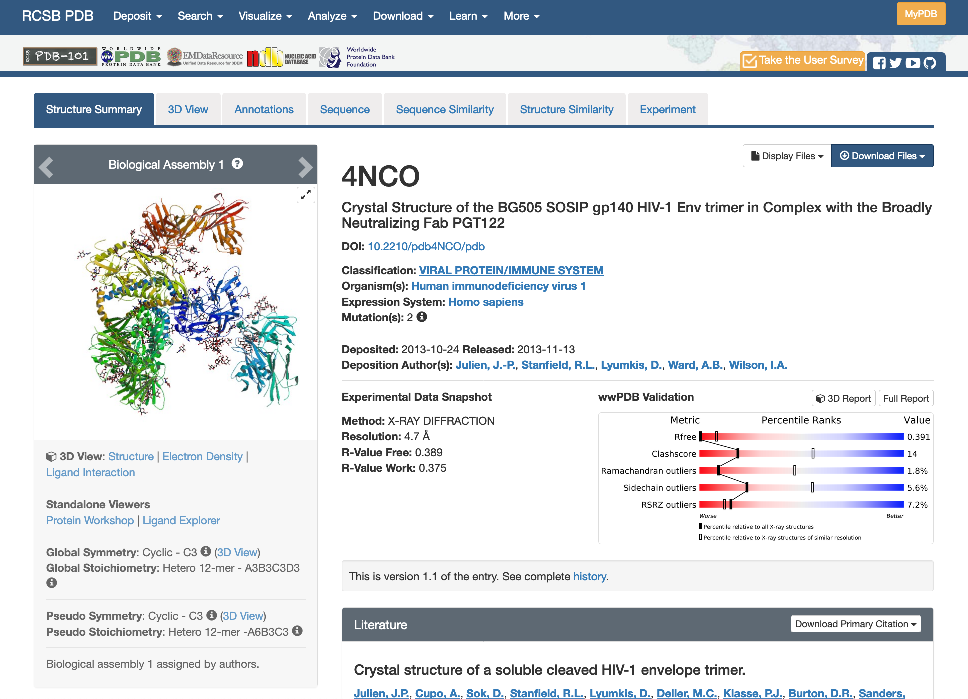

In [6]:
img = Image.open('./PDB_screenshot.png')
w, h = img.size 
img.resize((w/2, h/2))

# Finding my footing

At first, I was going to base this project on the search function in the PDB website: enter a search term, and pull out the crystallographic conditions of all the hits that come up. The url for a particular structure includes its PDB ID - for example, the url for the screenshot above is https://www.rcsb.org/structure/4nco. So I figured I would make a list of the PDB IDs in the results and go to their pages sequentially to pull out the conditions. But it didn't work out as expected:

In the screenshot below, you can see in black that I did a text search for "hiv gp140." But the url for this page is http://www.rcsb.org/pdb/results/results.do?tabtoshow=Current&qrid=47E207C1. I couldn't figure out where this came from or how to use it... So I scrapped the idea of inputting a search term into the PDB search box.

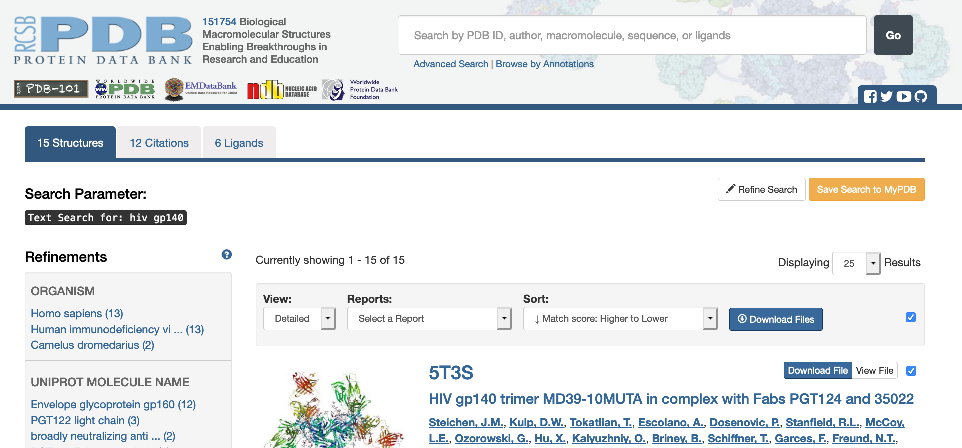

In [7]:
img2 = Image.open('./PDB_search.png')
w, h = img2.size 
img2.resize((w/2, h/2))

After searching around the PDB for a bit, I came across this:
There's apparently a service on the PDB website that you can use to access the data more easily. Among the things on this page, I found an engine that could do a BLAST search of a sequence and then pull up the PDB IDs of related sequences. To be quite honest, I still don't really understand how this service works. But it did seem to work, so I decided to use it.

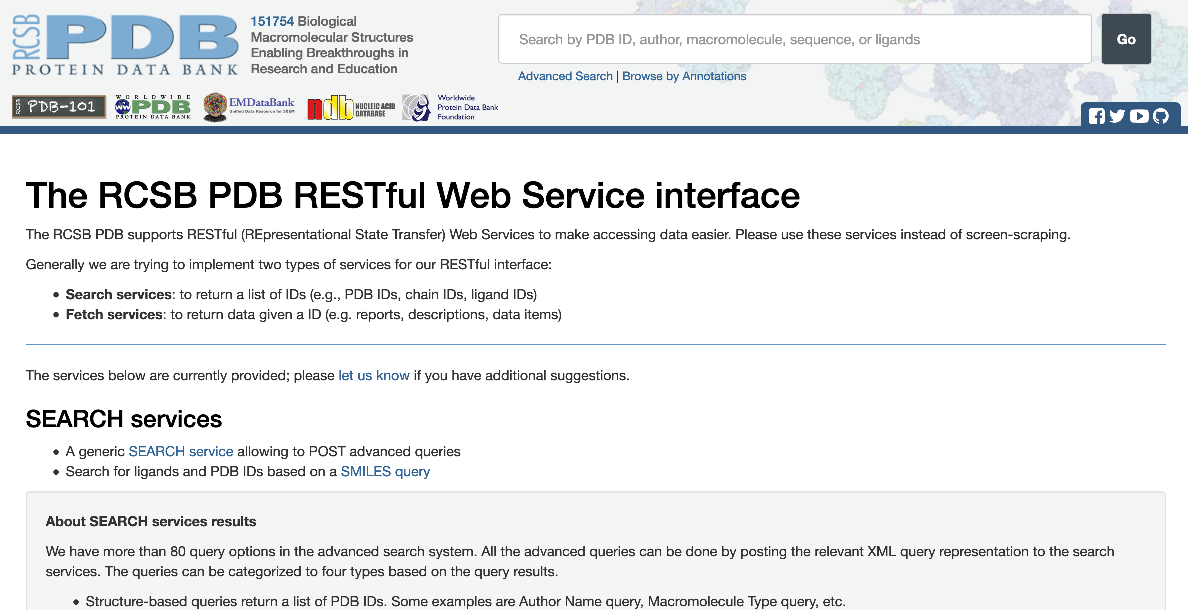

In [495]:
img3 = Image.open('./Project2/Restful.png')
w, h = img3.size 
img3.resize((w/2, h/2))

The service I'm using produces an HTML page that looks like the screenshot below:

The url looks like this: https://www.rcsb.org/pdb/rest/getBlastPDB1?sequence=VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTAVAHVDDMPNAL&eCutOff=10.0&matrix=BLOSUM62&outputFormat=HTML. I figured I could just swap out the sequence in the url with whatever the sequence is for my protein of interest.

From the results on the page I would obtain the PDB IDs and continue with the latter part of my original plan: go to the pages for each of those PDB IDs and pull out the conditions.

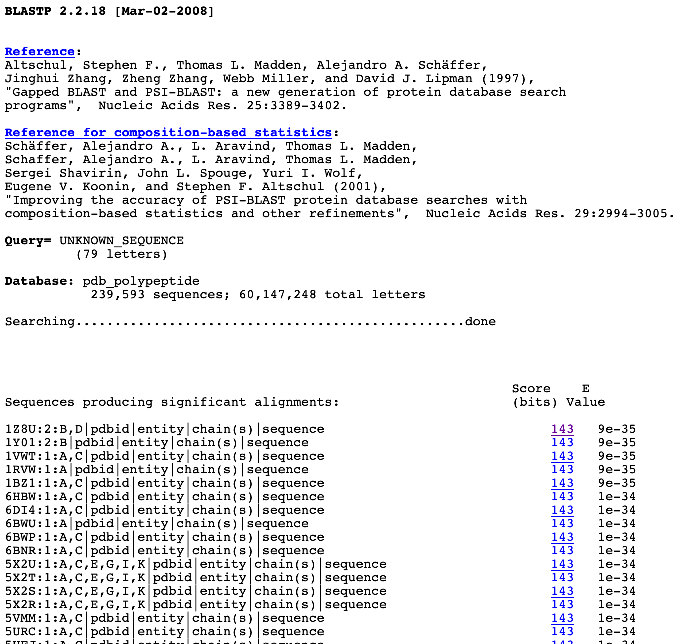

In [8]:
img5 = Image.open('./Output.png')
w, h = img5.size 
img5.resize((w/2, h/2))

# Okay, let's begin. But one last thing: Outline of the process, and a big caveat

First, I would like to provide an outline of the process:
- Select a protein of interest (hereafter referred to as POI). Either come armed with the sequence for your POI, or download the Fasta file for its sequence.
 - If using the Fasta file, extract the sequence from the Fasta file.
- Protein BLAST search and find the PDB IDs of proteins with similar sequences.
 - Note that by virtue of being in the PDB, we know the structure. Many proteins will have similar sequences to your POI but will not show up in this search because their structures have not been solved yet.
- Isolate the PDB IDs and put them into the basic PDB url for a structure, to open the PDB pages for those structures.
- Use BeautifulSoup to extract the crystallization conditions of those structures from the PDB pages.
- Plot the crystallization conditions.

Note that below, I have two chunks under big headers:
- The first run-through, where I'm just figuring things out
- The second run-through, where I try to put things into a function

Feel free to skip to the second run-through if you want.

Lastly, the big caveat: This project is more out of curiosity than true usefulness. As I mentioned above, crystallography is known to be a very empirical endeavor, where you often hear the mantra "every protein is different," so knowing the results of this project may not truly be helpful in any meaningful way. Plus, there are other limitations, such as:
- The PDB contains a lot of structures of biological complexes, e.g. structures of protein A and B bound to each other. But this search is only based on the one sequence that you put in.
- Another convoluting factor is that the PDB contains lots of similar structures: e.g. protein A mutant A, protein A mutant B, protein A mutant C; or protein A-molecule A complex, protein A-molecule B complex, protein A-molecule C complex, etc. I suppose the similarity in a lot of the entries is helpful if you just want to find the general conditions that your POI crystallizes in, but unhelpful if you're trying to find the conditions for truly different proteins that are sequence-similar to your POI.

In [1]:
# Just the usual: Check the current working directory - where am I?
import os
os.getcwd()

'/Users/Shu/PycharmProjects/spring2019-solo-project-shuzhang96/Project2'

# First run-through: figure out how to do things step by step

### Example protein of interest: hemoglobin subunit alpha

This is a step-by-step of what I went through before I tried to put any of the steps into a function. 

I downloaded the Fasta file containing the sequence on UniProt: https://www.uniprot.org/uniprot/P69905. A Fasta file looks like the screenshot below, with a header up top and then the sequence broken up into lines. Just to be clear, we do not want these lines.

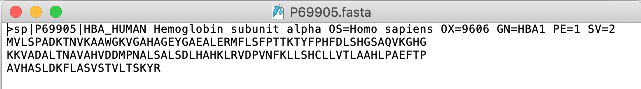

In [5]:
img4 = Image.open('./Hemoglobin_fasta.png')
w, h = img4.size 
img4.resize((w/2, h/2))

In [10]:
# Write a function to remove the first line from the Fasta file and join the lines in the sequence, to create a continuous sequence.
def get_Fasta_seq(fileloc):
    lines = open(fileloc, 'r').readlines()
    new_lines = [line.replace('\n', '') for line in lines[1:]]
    sequence = ''.join(new_lines)
    return sequence

In [11]:
# Open the Fasta file named 'Hemoglobin_alpha.fasta' and print out the continuous sequence.
get_Fasta_seq('./Hemoglobin_alpha.fasta')

'MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR'

In [12]:
# Or if you're not starting with the Fasta file, you can just go ahead and input the sequence.
sequence = 'MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR'

In [13]:
# Put the sequence into the URL of the page that will give PDB ID codes based on BLAST similarity (I do not know if this service has a name)
url = 'https://www.rcsb.org/pdb/rest/getBlastPDB1?sequence=' + sequence + '&eCutOff=10.0&matrix=BLOSUM62'

In [14]:
# Turn the search results into soup so that I can pull out the PDB IDs
page = urllib2.urlopen(url)
soup = BeautifulSoup(page, 'html.parser')

In [15]:
# This is the first 50 lines of the soup.
# There is a chunk of text at the top. 
# Under that, there are the first 10 or so PDB IDs with sequences producing significant alignments.
print('\n'.join(soup.prettify().splitlines()[:50]))

<html>
 <title>
  BLAST Search Results
 </title>
 <body alink="#660099" bgcolor="#FFFFFF" link="#0000FF" vlink="#660099">
  <pre>
<b>BLASTP 2.2.18 [Mar-02-2008]</b>


<b><a href="http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?db=PubMed&amp;cmd=Retrieve&amp;list_uids
=9254694&amp;dopt=Citation">Reference</a>:</b>
Altschul, Stephen F., Thomas L. Madden, Alejandro A. Schäffer, 
Jinghui Zhang, Zheng Zhang, Webb Miller, and David J. Lipman (1997), 
"Gapped BLAST and PSI-BLAST: a new generation of protein database search
programs",  Nucleic Acids Res. 25:3389-3402.

<b><a href="http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?db=PubMed&amp;cmd=Retrieve&amp;list_uids
=11452024&amp;dopt=Citation">Reference for composition-based statistics</a>:</b>
Schäffer, Alejandro A., L. Aravind, Thomas L. Madden, 
Schaffer, Alejandro A., L. Aravind, Thomas L. Madden,
Sergei Shavirin, John L. Spouge, Yuri I. Wolf,  
Eugene V. Koonin, and Stephen F. Altschul (2001), 
"Improving the accuracy of PSI-BLAST protein 

In [16]:
# For now, print just the top hit for alignment. It's on line 39.
split = soup.prettify().split('\n')
print(str(split[39]))

1Z8U:2:B,D|pdbid|entity|chain(s)|sequence                             <a href="#37108">253</a>   1e-67


In [17]:
# Print the top 10 hits for alignment. Again, it starts with line 39.
byline = soup.prettify().splitlines()
print('\n'.join(byline[39:(39+10)]))

1Z8U:2:B,D|pdbid|entity|chain(s)|sequence                             <a href="#37108">253</a>   1e-67
1Y01:2:B|pdbid|entity|chain(s)|sequence                               <a href="#35114">253</a>   1e-67
1BZ1:1:A,C|pdbid|entity|chain(s)|sequence                             <a href="#2887">253</a>   1e-67
3IA3:2:B,D|pdbid|entity|chain(s)|sequence                             <a href="#83451">252</a>   2e-67
1C7D:1:A|pdbid|entity|chain(s)|sequence                               <a href="#3208">251</a>   2e-67
1O1N:1:A|pdbid|entity|chain(s)|sequence                               <a href="#20439">251</a>   3e-67
1BAB:1:A,C|pdbid|entity|chain(s)|sequence                             <a href="#1941">251</a>   3e-67
1O1P:1:A|pdbid|entity|chain(s)|sequence                               <a href="#20442">251</a>   4e-67
1C7C:1:A|pdbid|entity|chain(s)|sequence                               <a href="#3205">251</a>   4e-67
1ABY:1:A|pdbid|entity|chain(s)|sequence                               <a href

In [18]:
# Print just the PDB code for the top hit (rather than the whole line). We need this to search it up again in the PDB website.
print(str(split[39])[0:4])

1Z8U


In [19]:
# Assign the PDB code above as 'pdbid'
pdbid = str(split[39])[0:4]

# Search this structure in the PDB and get the soup from the results of that search
url2 = 'https://www.rcsb.org/pdb/explore/materialsAndMethods.do?structureId=' + pdbid
soup2 = BeautifulSoup(urllib2.urlopen(url2), 'html.parser')

In [21]:
# Find the conditions used for that structure
conditions = soup2.find_all('td')[3]
print(conditions.get_text())

MES, PEG-2000 monomethyl ether, pH 6.5, VAPOR DIFFUSION, HANGING DROP, temperature 277K


In [22]:
# Turn the result into a string (in case we need it that way later)
str(conditions.get_text())

'MES, PEG-2000 monomethyl ether, pH 6.5, VAPOR DIFFUSION, HANGING DROP, temperature 277K'

# Second run-through: Making a function

In [23]:
# Write function to print the top n PDB hits based on sequence similarity.

# Since sometimes people carelessly mix up DNA and protein sequences, I wanted to build in a checkpoint.
# If the sequence you put in contains all of the characters in ACGT, then it will suggest that it's DNA.
# This isn't perfect of course, like if your DNA sequence only contains ACG then the program will not catch this mistake.

def find_pdbid(n):
    """ For a sequence you input, print the top n PDB hits based on sequence similarity. """
    sequence = raw_input('Input a protein sequence')
    if set(sequence) == {'A', 'C', 'G', 'T'}:
        return 'DNA sequence detected. Please input protein amino acid sequence.'
    else: 
        url = 'https://www.rcsb.org/pdb/rest/getBlastPDB1?sequence=' + sequence + '&eCutOff=10.0&matrix=BLOSUM62'
        page = urllib2.urlopen(url)
        soup = BeautifulSoup(page, 'html.parser')
        byline = soup.prettify().splitlines()
        print('\n'.join(byline[39:(39+n)]))

In [24]:
# Example sequence (same as above): 'MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR'
find_pdbid(10)

Input a protein sequence MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR


1Z8U:2:B,D|pdbid|entity|chain(s)|sequence                             <a href="#37108">253</a>   1e-67
1Y01:2:B|pdbid|entity|chain(s)|sequence                               <a href="#35114">253</a>   1e-67
1BZ1:1:A,C|pdbid|entity|chain(s)|sequence                             <a href="#2887">253</a>   1e-67
3IA3:2:B,D|pdbid|entity|chain(s)|sequence                             <a href="#83451">252</a>   2e-67
1C7D:1:A|pdbid|entity|chain(s)|sequence                               <a href="#3208">251</a>   2e-67
1O1N:1:A|pdbid|entity|chain(s)|sequence                               <a href="#20439">251</a>   3e-67
1BAB:1:A,C|pdbid|entity|chain(s)|sequence                             <a href="#1941">251</a>   3e-67
1O1P:1:A|pdbid|entity|chain(s)|sequence                               <a href="#20442">251</a>   4e-67
1C7C:1:A|pdbid|entity|chain(s)|sequence                               <a href="#3205">251</a>   4e-67
1ABY:1:A|pdbid|entity|chain(s)|sequence                               <a href

In [27]:
def find_conditions_try1(n):
    """ Obtain the crystallization conditions for n hits from results above. """
    for i in range(39, 39 + n):
        split = soup.prettify().split('\n')
        pdbid =  str(split[i])[0:4]
        pdbid_url = 'https://www.rcsb.org/pdb/explore/materialsAndMethods.do?structureId=' + pdbid
        new_soup = BeautifulSoup(urllib2.urlopen(pdbid_url), 'html.parser')
        conditions = new_soup.find_all('td')[3]
        print(conditions.get_text())

In [28]:
find_conditions_try1(15)

MES, PEG-2000 monomethyl ether, pH 6.5, VAPOR DIFFUSION, HANGING DROP, temperature 277K
MES, PEG2000, pH 6.5, VAPOR DIFFUSION, HANGING DROP, temperature 277K
α = 90
0.1 M MES, pH 6.5, 4% acetonitrile and 14.5% (w/v) PEG3000, VAPOR DIFFUSION, HANGING DROP, temperature 277K
α = 90
α = 90
β = 99.3
α = 90
α = 90
α = 90
α = 90
α = 90
10-20% PEG6000, 100mM Hepes pH 7.4
3.2M Na/K Phosphate
3.4M Na Phosphate/NH4 Sulfate


The output above reveals something interesting. Where I expected to see the crystallographic conditions, I see the dimensions of the stucture's unit cell instead (alpha and beta are two of the angles). So I went to those webpages and realized that those pages did not list the conditions. This could be because of two reasons:
- The conditions are simply not listed on the webpage.
- The structure was resolved through a method that was not X-ray crystallography.
The code simply takes the third 'td' element, and when the conditions are not there, that becomes the angles of the unit cell.

So I updated the final find_conditions function to reflect this, and also to put the output in a nicer-looking table.So I updated the final find_conditions function to reflect this, and also to put the output in a nicer-looking table. That is, structures resolved from cryo-EM will output "Electron microscopy," and structures that either came from another method or were X-ray structures that were missing conditions will show up as "N/A."

In [29]:
def find_conditions(n):
    """ Obtain the crystalization conditions for n hits from results above. Put in a table with the name of the structure. """
    
    cond_list = []
    name_list = []
    
    for i in range(39, 39 + n):
        
        split = soup.prettify().split('\n')
        pdbid =  str(split[i])[0:4]
        pdbid_url = 'https://www.rcsb.org/pdb/explore/materialsAndMethods.do?structureId=' + pdbid
        new_soup = BeautifulSoup(urllib2.urlopen(pdbid_url), 'html.parser')
        
        conditions = new_soup.find_all('td')[3]
        string = str(conditions)
        if '=' in string and 'ELECTRON MICROSCOPY' in soup.find_all('h3'):
            cond_list.append('Electron Microscopy')
        elif '=' in string:
            cond_list.append('N/A')
        else:
            cond_list.append(str(conditions.get_text()))
            
        name_list.append(str(new_soup.find_all('title'))[39:-32])
        
    return pd.DataFrame(list(zip(name_list, cond_list)), columns = ('Entity Name','Crystallization Conditions'))

    pd.set_option('display.max_colwidth', -1)

In [30]:
find_conditions(5)

,Entity Name,Crystallization Conditions
0,1Z8U: Crystal structure of oxidized alpha hemo...,"MES, PEG-2000 monomethyl ether, pH 6.5, VAPOR ..."
1,1Y01: Crystal structure of AHSP bound to Fe(II...,"MES, PEG2000, pH 6.5, VAPOR DIFFUSION, HANGING..."
2,1BZ1: HEMOGLOBIN (ALPHA + MET) VARIANT,N/A
3,3IA3: A cis-proline in alpha-hemoglobin stabil...,"0.1 M MES, pH 6.5, 4% acetonitrile and 14.5% (..."
4,1C7D: DEOXY RHB1.2 (RECOMBINANT HEMOGLOBIN),N/A


How about if we want to plot the most common conditions? There's a caveat here, which is that the conditions are not super well-standardized. For example, the entires "PEG 2000", "PEG-2000", and "polyethylene glycol 2000" would all show up in different bars, even though they're all the same chemical. But it's still kind of helpful anyway.

<BarContainer object of 9 artists>

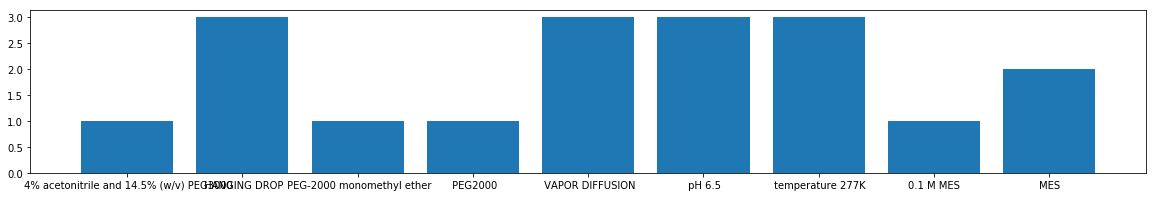

In [33]:
columns = find_conditions(5).iloc[:,1]
nlist = [item.split(',') for item in columns]
nlist = [val for sublist in nlist for val in sublist]
# Remove all N/A values.
nlist = [x for x in nlist if x != 'N/A']
keys, counts = np.unique(nlist, return_counts = True)
plt.figure(figsize=(20,3))
plt.bar(keys, counts)

# Final Functions

In [37]:
# Get a sequence from a Fasta file.
def get_Fasta_seq(fileloc):
    lines = open(fileloc, 'r').readlines()
    new_lines = [line.replace('\n', '') for line in lines[1:]]
    sequence = ''.join(new_lines)
    return sequence

# Get conditions from a sequence.
def get_conditions(n):
    """ For a sequence you input, print the top n PDB hits based on sequence similarity. """
    
    sequence = raw_input('Input a protein sequence')
    
    if set(sequence) == {'A', 'C', 'G', 'T'}:
        return 'DNA sequence detected. Please input protein amino acid sequence.'
    
    else: 
        url = 'https://www.rcsb.org/pdb/rest/getBlastPDB1?sequence=' + sequence + '&eCutOff=10.0&matrix=BLOSUM62'
        page = urllib2.urlopen(url)
        soup = BeautifulSoup(page, 'html.parser')
        byline = soup.prettify().splitlines()

        cond_list = []
        name_list = []
    
        for i in range(39, 39 + n):

            split = soup.prettify().split('\n')
            pdbid =  str(split[i])[0:4]
            pdbid_url = 'https://www.rcsb.org/pdb/explore/materialsAndMethods.do?structureId=' + pdbid
            new_soup = BeautifulSoup(urllib2.urlopen(pdbid_url), 'html.parser')

            conditions = new_soup.find_all('td')[3]
            string = str(conditions)
            if '=' in string and 'ELECTRON MICROSCOPY' in soup.find_all('h3'):
                cond_list.append('Electron Microscopy')
            elif '=' in string:
                cond_list.append('N/A')
            else:
                cond_list.append(str(conditions.get_text()))

            name_list.append(str(new_soup.find_all('title'))[39:-32])

        conditions = pd.DataFrame(list(zip(name_list, cond_list)), columns = ('Entity Name','Crystallization Conditions'))
        return conditions

        pd.set_option('display.max_colwidth', -1)

# Plot the conditions
def plot_conditions(n): 
    nlist = [item.split(',') for item in get_conditions(n).iloc[:,1]]
    nlist = [val for sublist in nlist for val in sublist]
    nlist = [x for x in nlist if x != 'N/A']
    keys, counts = np.unique(nlist, return_counts = True)
    plt.figure(figsize=(18,3))
    plt.bar(keys, counts)

In [35]:
# Example of getting conditions
get_conditions(10)

Input a protein sequence MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR


,Entity Name,Crystallization Conditions
0,1Z8U: Crystal structure of oxidized alpha hemo...,"MES, PEG-2000 monomethyl ether, pH 6.5, VAPOR ..."
1,1Y01: Crystal structure of AHSP bound to Fe(II...,"MES, PEG2000, pH 6.5, VAPOR DIFFUSION, HANGING..."
2,1BZ1: HEMOGLOBIN (ALPHA + MET) VARIANT,N/A
3,3IA3: A cis-proline in alpha-hemoglobin stabil...,"0.1 M MES, pH 6.5, 4% acetonitrile and 14.5% (..."
4,1C7D: DEOXY RHB1.2 (RECOMBINANT HEMOGLOBIN),N/A
5,"1O1N: Deoxy hemoglobin (A-GLYGLYGLY-C:V1M,L29W...",N/A
6,1BAB: HEMOGLOBIN THIONVILLE: AN ALPHA-CHAIN VA...,N/A
7,"1O1P: Deoxy hemoglobin (A-GLY-C:V1M; B,D:V1M,C...",N/A
8,1C7C: DEOXY RHB1.1 (RECOMBINANT HEMOGLOBIN),N/A
9,1ABY: CYANOMET RHB1.1 (RECOMBINANT HEMOGLOBIN),N/A


Input a protein sequence MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR


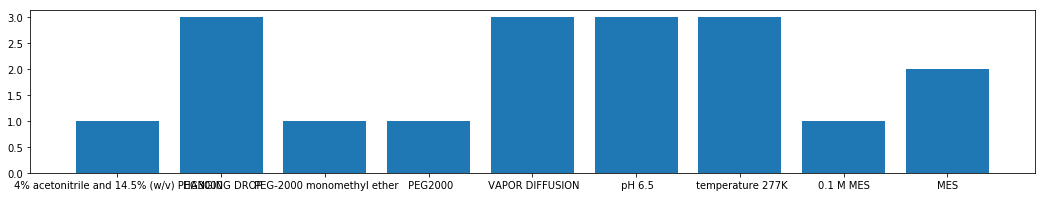

In [38]:
# Example of plotting conditions
plot_conditions(5)